In [1]:
from openff.toolkit.topology.molecule import FrozenMolecule, Molecule
# from openff.toolkit.utils.toolkits import RDKitToolkitWrapper, OpenEyeToolkitWrapper
from rdkit import Chem



In [2]:
mol = Molecule.from_smiles('CCCCCCCCCCCCCC')
mol.generate_conformers()
confs = mol._conformers
mol._conformers = [mol._conformers[0]]

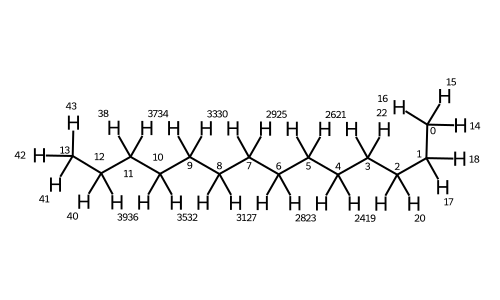

In [3]:
mol.visualize(backend='rdkit')

In [4]:
def get_smarts_substructure_from_rdkit_idx(mol, ids):
    # assume either Molecule or RDKit molecule
    if type(mol) == Molecule:
        rdmol = mol.to_rdkit()
    else:
        rdmol = mol
    smarts = Chem.MolFragmentToSmarts(rdmol, atomsToUse = ids)
    return smarts, rdmol
def get_atoms_between(mol, exclusive_wall_ids, seed, inclusive_wall_ids=[]):
    # a fun little function that gets all atom ids until it hits "walls" specified by the user
    wall_ids = [*exclusive_wall_ids, *inclusive_wall_ids]
    if len(wall_ids) < 2:
        print("must provide more two or more atom ids")
        return -1
    found = [] # atom ids found that we need not go over again
    active = [seed] # atom ids where the algorithm is currently centered 
    n = 0
    rdmol = mol.to_rdkit() #makes sure ids are the rdkit ids
    while len(active) != 0 and n < 2*mol.n_atoms:
        for active_idx in active:
            active_atom = rdmol.GetAtomWithIdx(active_idx)
            for neighbor in active_atom.GetNeighbors():
                idx = neighbor.GetIdx()
                if (idx in found) or (idx in active):
                    continue
                elif (idx in wall_ids):
                    if idx in inclusive_wall_ids:
                        found.append(idx)
                    continue
                else:
                    active.append(idx)
            active.remove(active_idx)
            found.append(active_idx)
    return found
        

In [7]:
selected_atoms = get_atoms_between(mol, [11,8], 10)
smarts, rdmol = get_smarts_substructure_from_rdkit_idx(mol, ids=selected_atoms)
print(smarts)


RuntimeError: Range Error
	idx
	Violation occurred on line 206 in file Code/GraphMol/ROMol.cpp
	Failed Expression: 10 < 2
	RDKIT: 2021.09.4
	BOOST: 1_74


In [8]:
mol.visualize(backend='rdkit', highlight_ids=selected_atoms)

NameError: name 'selected_atoms' is not defined

In [9]:
mol.chemical_environment_matches('[#6:1](-[#6:2](-[H:3])-[H:4])(-[H:5])-[H:6]')

[]

In [9]:
qmol = Chem.MolFromSmarts(smarts)

In [10]:
rdmol.GetSubstructMatches(qmol, useChirality=True)

((0, 1, 17, 18, 14, 15),
 (0, 1, 17, 18, 14, 16),
 (0, 1, 17, 18, 15, 16),
 (1, 2, 19, 20, 17, 18),
 (2, 3, 21, 22, 19, 20),
 (3, 4, 23, 24, 21, 22),
 (4, 5, 25, 26, 23, 24),
 (5, 6, 27, 28, 25, 26),
 (6, 7, 29, 30, 27, 28),
 (7, 8, 31, 32, 29, 30),
 (8, 9, 33, 34, 31, 32),
 (9, 10, 35, 36, 33, 34),
 (10, 11, 37, 38, 35, 36),
 (11, 12, 39, 40, 37, 38),
 (12, 13, 41, 42, 39, 40),
 (12, 13, 41, 43, 39, 40),
 (12, 13, 42, 43, 39, 40))

In [11]:
# a = '[#6:1](-[#6:2](-[H:3])-[H:4])(-[H:5])-[H:6]'
a = '[#6](-[#6](-[H])-[H])(-[H])-[H]'
rdmol = Chem.MolFromSmarts(a)
for atom in rdmol.GetAtoms():
    print(atom.GetIdx())

0
1
2
3
4
5


In [12]:
mol = Molecule.from_rdkit(rdmol, allow_undefined_stereo=True)

RuntimeError: Pre-condition Violation
	getNumImplicitHs() called without preceding call to calcImplicitValence()
	Violation occurred on line 183 in file Code/GraphMol/Atom.cpp
	Failed Expression: d_implicitValence > -1
	RDKIT: 2021.09.4
	BOOST: 1_74


# PDB Reading For Rubber

In [30]:
file = 'polymer_examples/rdkit_simple_polymers/naturalrubber.pdb'

mol = Molecule.from_pdb(file)
rdmol = Chem.rdmolfiles.MolFromPDBFile(file)
assigned_atoms = set()
for atom in mol.atoms:
    if atom.atomic_number < 0:
        atom._atomic_number = -atom.atomic_number
    dictionary = eval(atom.metadata['dict']) # this is very not good
    # basically this is a very 
    try:
        test = dictionary['already_matched']
        assigned_atoms.add(atom.molecule_atom_index)
    except Exception:
        pass
print(assigned_atoms)

UniConn
[#6](-[H])(-[H])(-[H])-[#6](=[#6](-[H])-[#6](-[H])-[H])-[#6](-[H])(-[H])-[H]
UniConn
[#6](-[H])(-[H])-[#6](=[#6](-[H])-[#6](-[H])(-[H])-[H])-[#6](-[H])(-[H])-[H]
BiConn
[#6](-[H])(-[H])-[#6](=[#6](-[H])-[#6](-[H])-[H])-[#6](-[H])(-[H])-[H]
N. of assigned nodes: 106 -- N. of atoms: 106
N. of assigned edges: 98 -- N. of bonds: 105
0 {'atomic_number': 6, 'formal_charge': 0, 'atom_name': 'C1', 'residue_name': 'UNL', 'residue_number': 0, 'already_matched': True, 'connors_residue_name': 'UniConn', 'connors_residue_number': 1, 'connors_atom_name': 'C1'}
Formal charge: 0
1 {'atomic_number': 1, 'formal_charge': 0, 'atom_name': 'H1', 'residue_name': 'UNL', 'residue_number': 0, 'already_matched': True, 'connors_residue_name': 'UniConn', 'connors_residue_number': 1, 'connors_atom_name': 'H1'}
Formal charge: 0
2 {'atomic_number': 1, 'formal_charge': 0, 'atom_name': 'H2', 'residue_name': 'UNL', 'residue_number': 0, 'already_matched': True, 'connors_residue_name': 'UniConn', 'connors_residue_

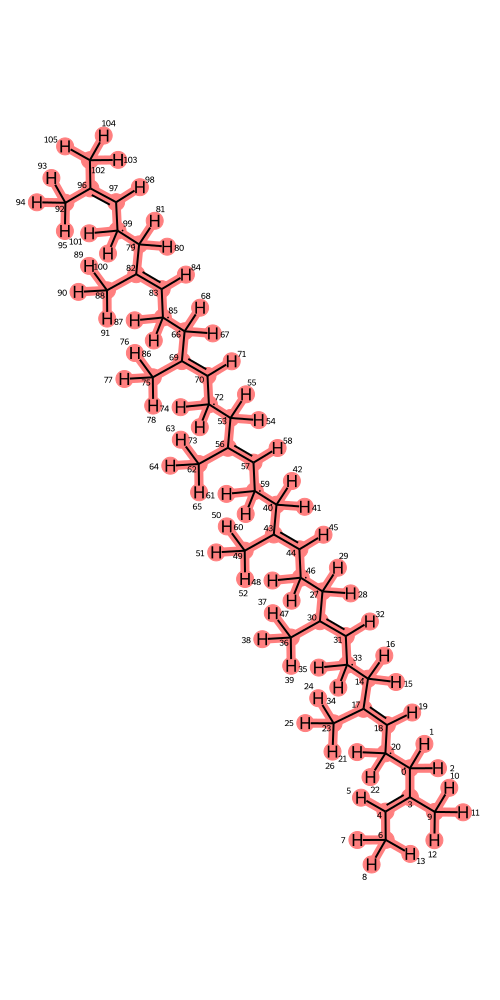

In [31]:
mol.visualize(backend='rdkit', height=1000, highlight_ids=list(assigned_atoms))

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Bonds with undefined stereochemistry are:
 - Bond 4 (atoms 3-4 of element (C-C)
 - Bond 18 (atoms 17-18 of element (C-C)
 - Bond 31 (atoms 30-31 of element (C-C)
 - Bond 44 (atoms 43-44 of element (C-C)
 - Bond 57 (atoms 56-57 of element (C-C)
 - Bond 70 (atoms 69-70 of element (C-C)
 - Bond 83 (atoms 82-83 of element (C-C)



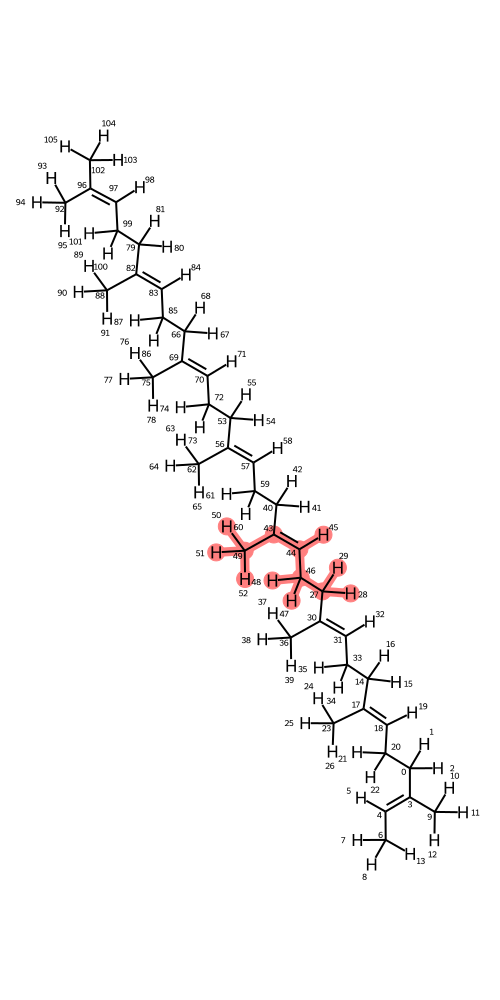

In [29]:
rdmol = Chem.rdmolfiles.MolFromPDBFile(file, removeHs=False)
newmol = Molecule.from_rdkit(rdmol, allow_undefined_stereo=True)
selected_atoms = get_atoms_between(mol, [40, 30], 43, inclusive_wall_ids = [])
smarts, rdmol_sub = get_smarts_substructure_from_rdkit_idx(rdmol, ids=selected_atoms)
newmol.visualize(backend='rdkit', height=1000, highlight_ids=list(selected_atoms))


In [21]:
rdmol = Chem.rdmolfiles.MolFromPDBFile(file, removeHs=False)
# for bond in rdmol.GetBonds():
#     print(bond.GetBondType())
c=0
for atom in rdmol.GetAtoms():
    if atom.GetAtomicNum() == 1:
        c+= 1
c

66

In [10]:
mol = Molecule.from_pdb(file)
mol

N. of assigned nodes: 0 -- N. of atoms: 2
N. of assigned edges: 0 -- N. of bonds: 1
0 {'atomic_number': 6, 'formal_charge': 0.0, 'atom_name': 'C', 'residue_name': 'UNL', 'residue_number': 0}
Formal charge: 0
1 {'atomic_number': -1, 'formal_charge': 0.0, 'atom_name': 'H', 'residue_name': 'UNL', 'residue_number': 0}
Formal charge: 0
(0, 1) {'bond_order': rdkit.Chem.rdchem.BondType.UNSPECIFIED}
Number of atoms before sanitization: 2


KeyError: -1

KeyError: -1

In [26]:
smarts

'[#6](-[H])(-[H])-[#6](=[#6](-[H])-[#6](-[H])(-[H])-[H])-[#6](-[H])(-[H])-[H]'

# PDB Reading for PAMAM

In [49]:
file = 'polymer_examples/rdkit_simple_polymers/PAMAM.pdb'

mol = Molecule.from_pdb(file)
rdmol = Chem.rdmolfiles.MolFromPDBFile(file)
assigned_atoms = set()
for atom in mol.atoms:
    if atom.atomic_number < 0:
        atom._atomic_number = -atom.atomic_number
    dictionary = eval(atom.metadata['dict']) # this is very not good
    # basically this is a very 
    try:
        test = dictionary['already_matched']
        assigned_atoms.add(atom.molecule_atom_index)
    except Exception:
        pass
print(assigned_atoms)


PAMAM
[#6](-[#6](-[#6](-[#7](-[#6](-[#6](-[#7](-[H])-[H])(-[H])-[H])(-[H])-[H])-[H])=[#8])(-[H])-[H])(-[H])-[H]
PAMAM
[#6](-[#6](-[#6](-[#7](-[#6](-[#6](-[#7])(-[H])-[H])(-[H])-[H])-[H])=[#8])(-[H])-[H])(-[H])-[H]
POLYETHYLENE
[#6:1](-[#6:2](-[H:3])-[H:4])(-[H:5])-[H:6]
PEPTIDE_BOND
[C:1](=[O:2])[N:3]([C:4])
N. of assigned nodes: 514 -- N. of atoms: 530
N. of assigned edges: 485 -- N. of bonds: 529
0 {'atomic_number': 7, 'formal_charge': 0.0, 'atom_name': 'N1', 'residue_name': 'UNL', 'residue_number': 0}
Formal charge: 0
1 {'atomic_number': 6, 'formal_charge': 0, 'atom_name': 'C1', 'residue_name': 'UNL', 'residue_number': 0, 'already_matched': True, 'connors_residue_name': 'POLYETHYLENE', 'connors_residue_number': 1, 'connors_atom_name': 'CA'}
Formal charge: 0
2 {'atomic_number': 6, 'formal_charge': 0, 'atom_name': 'C2', 'residue_name': 'UNL', 'residue_number': 0, 'already_matched': True, 'connors_residue_name': 'POLYETHYLENE', 'connors_residue_number': 1, 'connors_atom_name': 'C'}
For

367 {'atomic_number': 1, 'formal_charge': 0, 'atom_name': 'HE0', 'residue_name': 'UNL', 'residue_number': 0, 'already_matched': True, 'connors_residue_name': 'PAMAM', 'connors_residue_number': 5, 'connors_atom_name': 'H5'}
Formal charge: 0
368 {'atomic_number': 1, 'formal_charge': 0, 'atom_name': 'HE1', 'residue_name': 'UNL', 'residue_number': 0, 'already_matched': True, 'connors_residue_name': 'PAMAM', 'connors_residue_number': 5, 'connors_atom_name': 'H6'}
Formal charge: 0
369 {'atomic_number': 1, 'formal_charge': 0, 'atom_name': 'HE2', 'residue_name': 'UNL', 'residue_number': 0, 'already_matched': True, 'connors_residue_name': 'PAMAM', 'connors_residue_number': 5, 'connors_atom_name': 'H3'}
Formal charge: 0
370 {'atomic_number': 1, 'formal_charge': 0, 'atom_name': 'HE3', 'residue_name': 'UNL', 'residue_number': 0, 'already_matched': True, 'connors_residue_name': 'PAMAM', 'connors_residue_number': 5, 'connors_atom_name': 'H4'}
Formal charge: 0
371 {'atomic_number': 1, 'formal_charge'

(176, 177) {'bond_order': 1}
(176, 450) {'bond_order': 1}
(176, 451) {'bond_order': 1}
(177, 206) {'bond_order': rdkit.Chem.rdchem.BondType.UNSPECIFIED}
(177, 210) {'bond_order': rdkit.Chem.rdchem.BondType.UNSPECIFIED}
(177, 529) {'bond_order': rdkit.Chem.rdchem.BondType.UNSPECIFIED}
(181, 182) {'bond_order': 1}
(181, 452) {'bond_order': 1}
(181, 453) {'bond_order': 1}
(182, 454) {'bond_order': 1}
(182, 455) {'bond_order': 1}
(183, 456) {'bond_order': 1}
(183, 457) {'bond_order': 1}
(184, 185) {'bond_order': 1}
(184, 189) {'bond_order': 2}
(185, 190) {'bond_order': 1}
(185, 458) {'bond_order': 1}
(186, 187) {'bond_order': 1}
(186, 188) {'bond_order': 2}
(187, 193) {'bond_order': 1}
(187, 459) {'bond_order': 1}
(190, 191) {'bond_order': 1}
(190, 460) {'bond_order': 1}
(190, 461) {'bond_order': 1}
(191, 192) {'bond_order': 1}
(191, 462) {'bond_order': 1}
(191, 463) {'bond_order': 1}
(192, 464) {'bond_order': 1}
(192, 465) {'bond_order': 1}
(193, 194) {'bond_order': 1}
(193, 466) {'bond_o

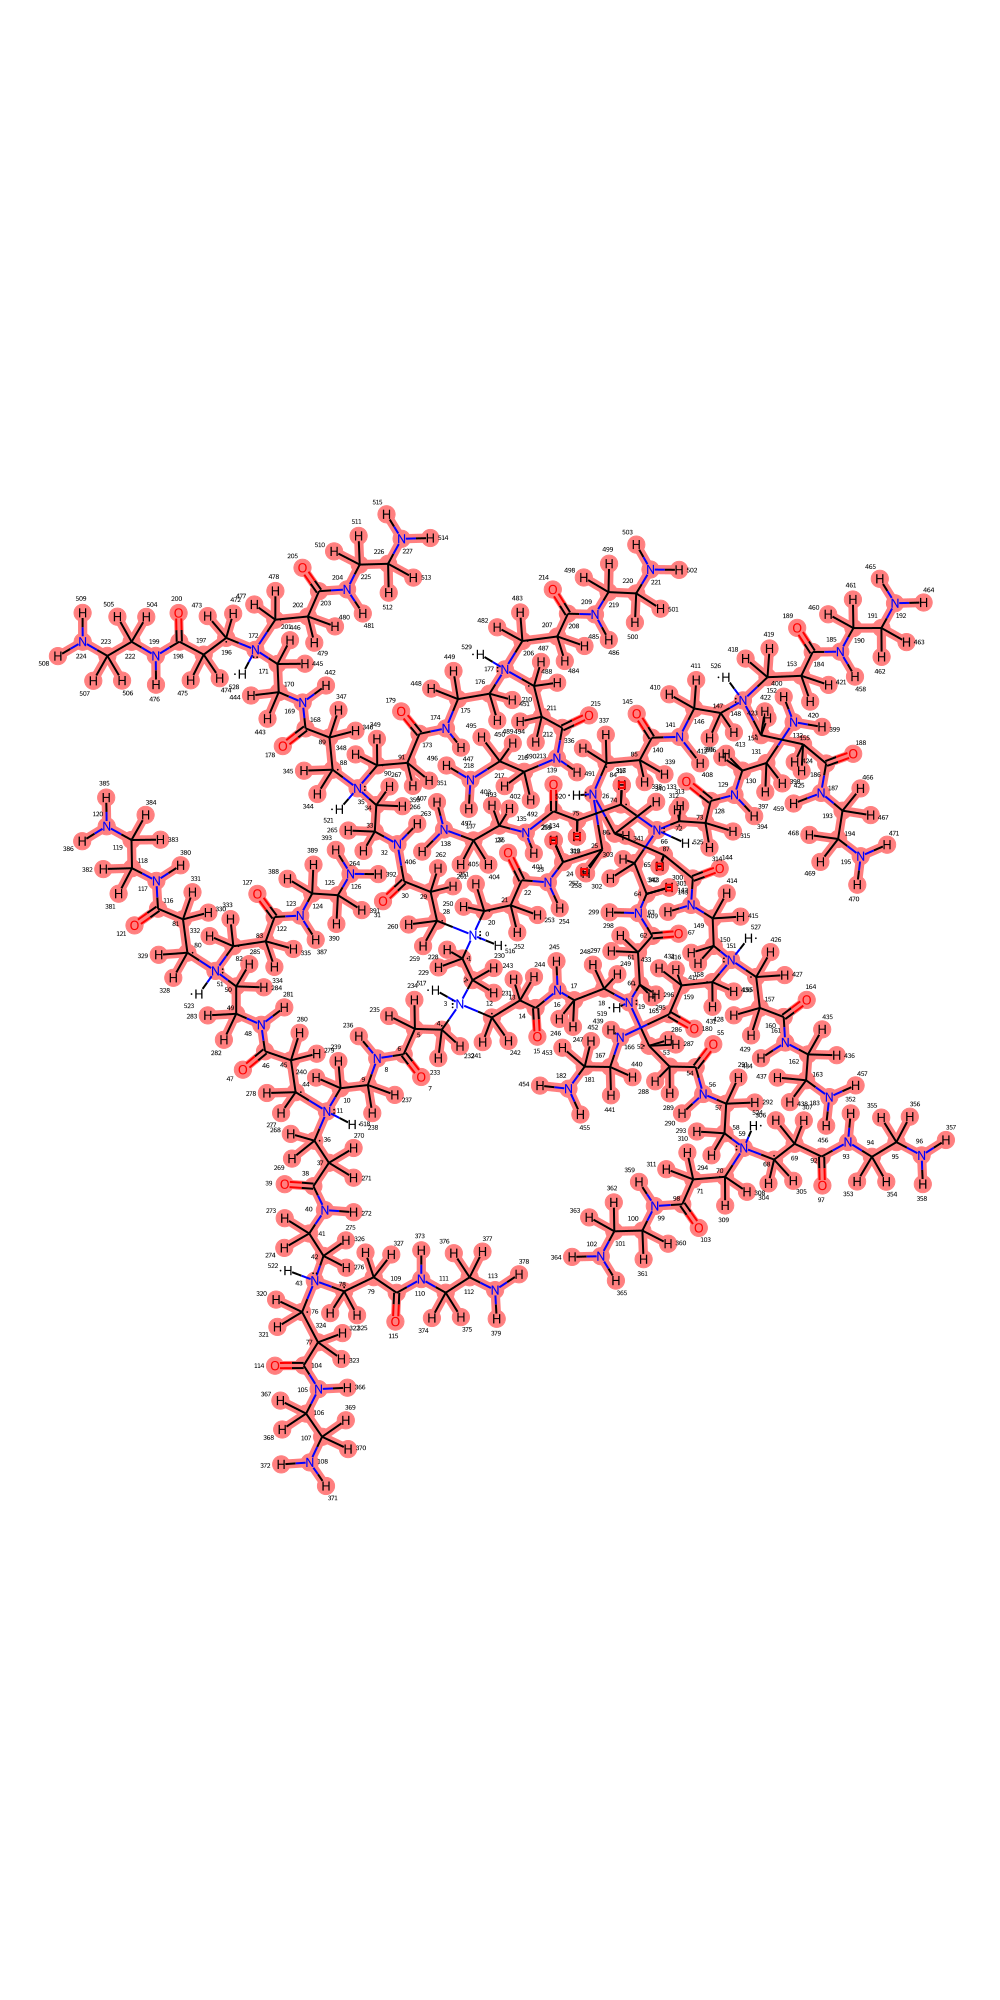

In [50]:
mol.visualize(backend='rdkit', height=2000, width=1000, highlight_ids=list(assigned_atoms))

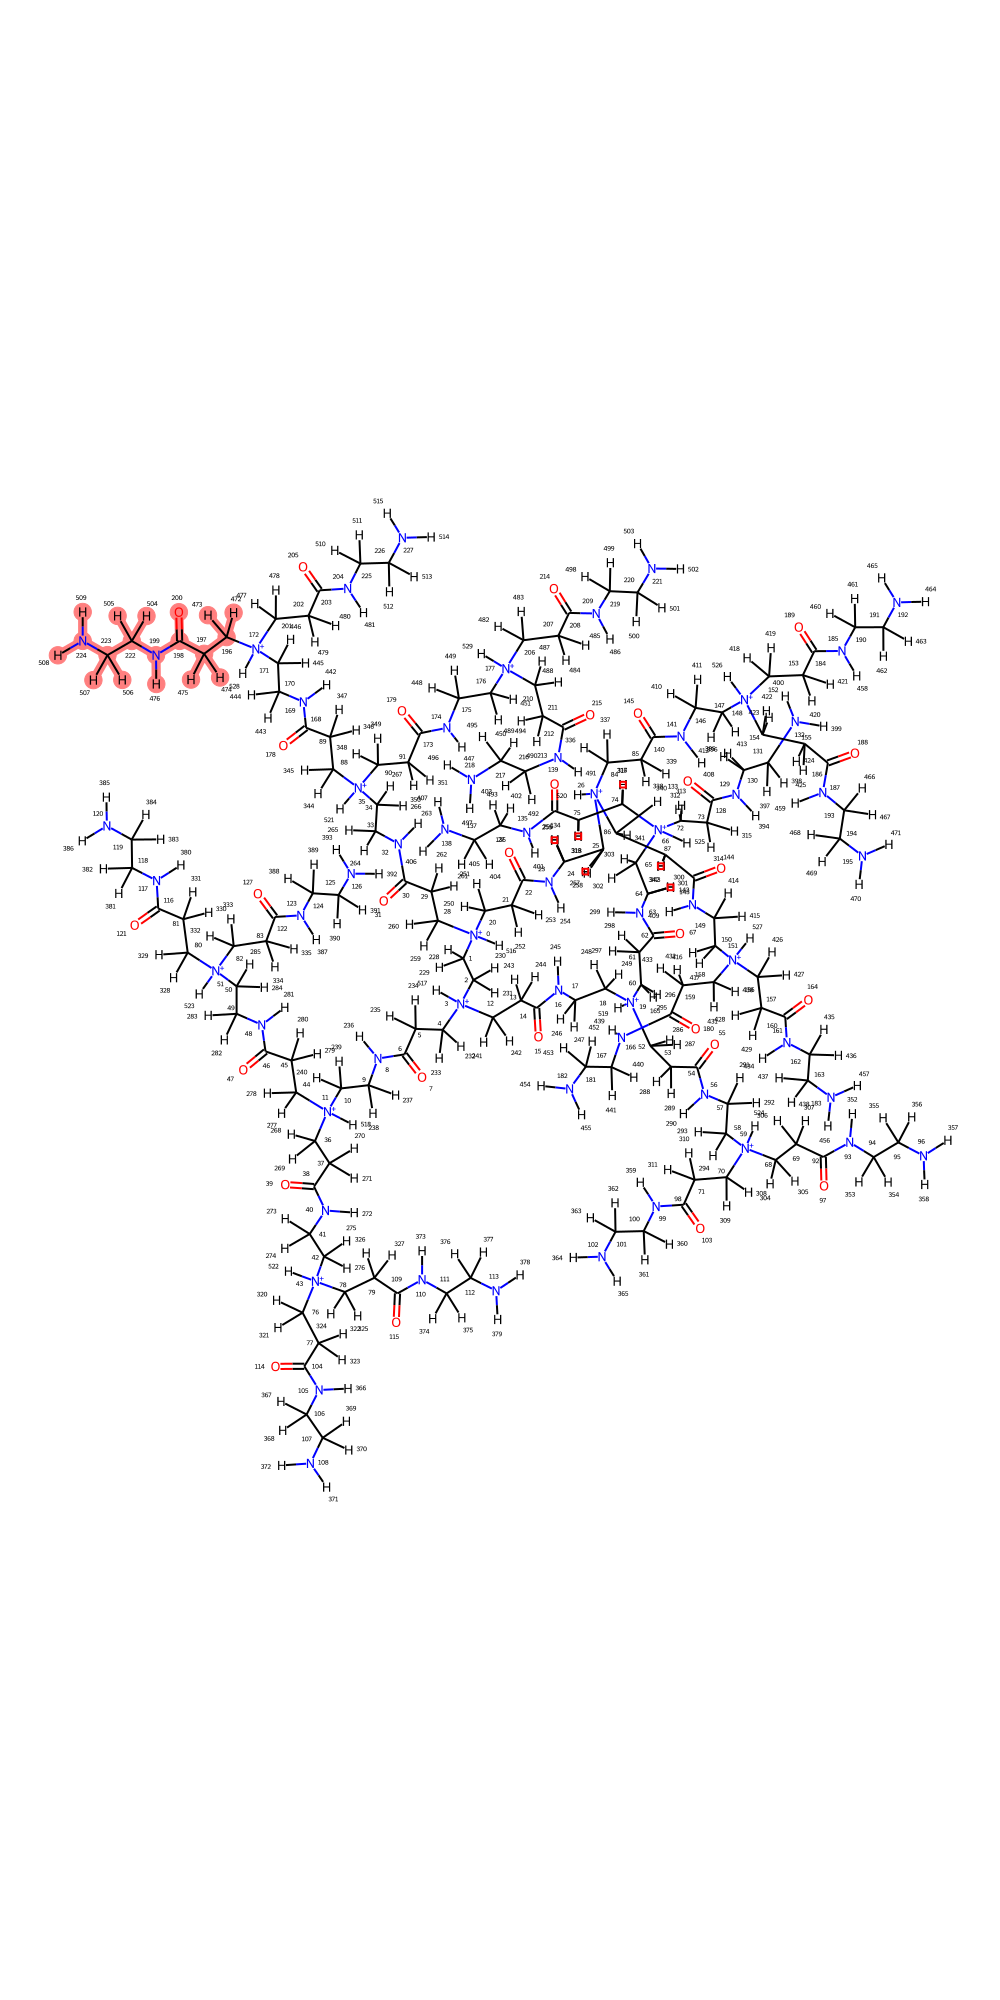

In [46]:
rdmol = Chem.rdmolfiles.MolFromPDBFile(file, removeHs=False)
newmol = Molecule.from_rdkit(rdmol, allow_undefined_stereo=True)
selected_atoms = get_atoms_between(mol, [172], 223, inclusive_wall_ids = [508, 509])
smarts, rdmol_sub = get_smarts_substructure_from_rdkit_idx(rdmol, ids=selected_atoms)
newmol.visualize(backend='rdkit', height=2000, width=1000, highlight_ids=list(selected_atoms))

# Vulcanized Rubber

In [78]:
file = 'polymer_examples/rdkit_simple_polymers/vulcanizedrubber.pdb'

mol = Molecule.from_pdb(file)
rdmol = Chem.rdmolfiles.MolFromPDBFile(file)
assigned_atoms = set()
for atom in mol.atoms:
    if atom.atomic_number < 0:
        atom._atomic_number = -atom.atomic_number
    dictionary = eval(atom.metadata['dict']) # this is very not good
    # basically this is a very 
    try:
        test = dictionary['already_matched']
        assigned_atoms.add(atom.molecule_atom_index)
    except Exception:
        pass
print(assigned_atoms)

POLYETHYLENE
[#6:1](-[#6:2](-[H:3])-[H:4])(-[H:5])-[H:6]
N. of assigned nodes: 24 -- N. of atoms: 103
N. of assigned edges: 20 -- N. of bonds: 106
0 {'atomic_number': 6, 'formal_charge': 0.0, 'atom_name': 'C1', 'residue_name': 'UNL', 'residue_number': 0}
Formal charge: 0
1 {'atomic_number': 6, 'formal_charge': 0.0, 'atom_name': 'C2', 'residue_name': 'UNL', 'residue_number': 0}
Formal charge: 0
2 {'atomic_number': 6, 'formal_charge': 0.0, 'atom_name': 'C3', 'residue_name': 'UNL', 'residue_number': 0}
Formal charge: 0
3 {'atomic_number': 6, 'formal_charge': 0, 'atom_name': 'C4', 'residue_name': 'UNL', 'residue_number': 0, 'already_matched': True, 'connors_residue_name': 'POLYETHYLENE', 'connors_residue_number': 1, 'connors_atom_name': 'CA'}
Formal charge: 0
4 {'atomic_number': 6, 'formal_charge': 0, 'atom_name': 'C5', 'residue_name': 'UNL', 'residue_number': 0, 'already_matched': True, 'connors_residue_name': 'POLYETHYLENE', 'connors_residue_number': 1, 'connors_atom_name': 'C'}
Formal c

[03:02:32] unrecognized bond type[03:02:32] unrecognized bond type[03:02:32] unrecognized bond type[03:02:32] unrecognized bond type[03:02:32] unrecognized bond type[03:02:32] unrecognized bond type[03:02:32] unrecognized bond type[03:02:32] unrecognized bond type[03:02:32] unrecognized bond type[03:02:32] unrecognized bond type[03:02:32] unrecognized bond type[03:02:32] unrecognized bond type[03:02:32] unrecognized bond type[03:02:32] unrecognized bond type[03:02:32] unrecognized bond type[03:02:32] unrecognized bond type[03:02:32] unrecognized bond type[03:02:32] unrecognized bond type[03:02:32] unrecognized bond type[03:02:32] unrecognized bond type[03:02:32] unrecognized bond type[03:02:32] unrecognized bond type[03:02:32] unrecognized bond type[03:02:32] unrecognized bond type[03:02:32] unrecognized bond type[03:02:32] unrecognized bond type[03:02:32] unrecognized bond type[03:02:32] unrecognized bond type[03:02:32] unrecognized bond type[03:02:32] unrecognized bond type[03:02:32]

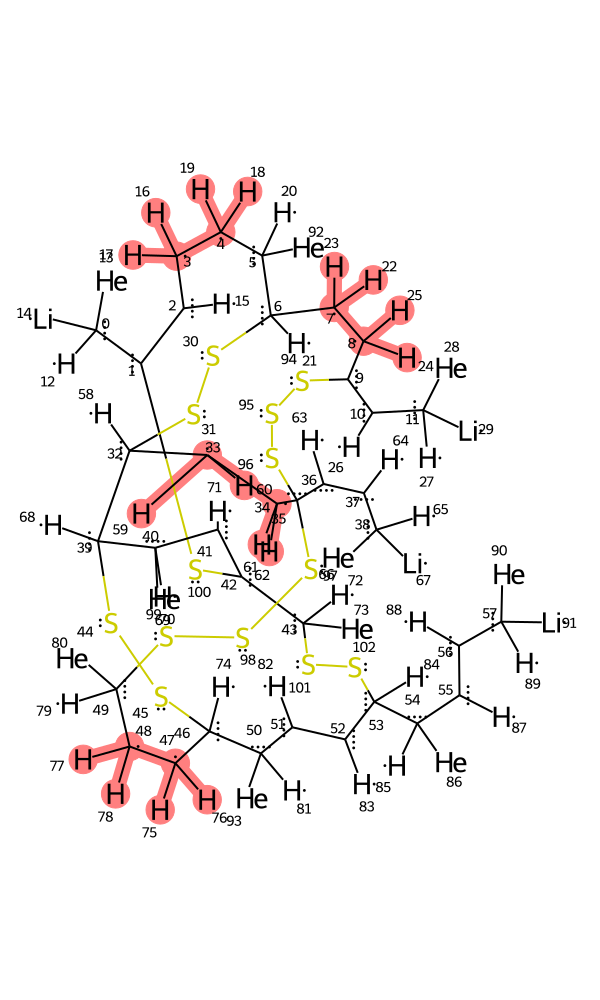

In [83]:
mol.visualize(backend='rdkit', height=1000, width=600, highlight_ids=list(assigned_atoms))

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Bonds with undefined stereochemistry are:
 - Bond 26 (atoms 9-10 of element (C-C)
 - Bond 47 (atoms 36-37 of element (C-C)
 - Bond 94 (atoms 55-56 of element (C-C)



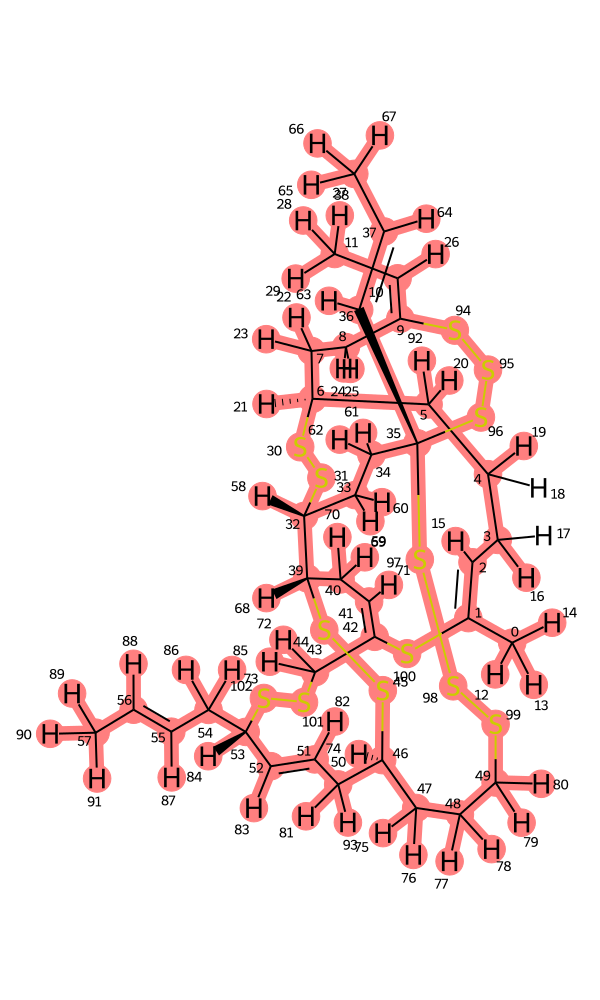

In [82]:
rdmol = Chem.rdmolfiles.MolFromPDBFile(file, removeHs=False)
newmol = Molecule.from_rdkit(rdmol, allow_undefined_stereo=True)
selected_atoms = get_atoms_between(mol, [17, 18], 50, inclusive_wall_ids = [])
smarts, rdmol_sub = get_smarts_substructure_from_rdkit_idx(rdmol, ids=selected_atoms)
newmol.visualize(backend='rdkit', height=1000, width=600, highlight_ids=list(selected_atoms))

# Looking at polyamide membrane block 1

In [70]:
block1 = """ATOM      1  H   UNL     1      22.643  19.990   6.793  0.00  0.00 
ATOM      2  O   UNL     1      29.932  23.811  10.355  0.00  0.00 
ATOM      3  C   UNL     1      18.271  22.376  12.460  0.00  0.00 
ATOM      4  C   UNL     1      18.612  21.071  12.084  0.00  0.00 
ATOM      5  C   UNL     1      19.695  20.521  12.722  0.00  0.00 
ATOM      6  H   UNL     1      17.313  22.754  12.075  0.00  0.00 
ATOM      7  N   UNL     1      17.608  20.255  11.663  0.00  0.00 
ATOM      8  H   UNL     1      19.776  19.428  12.744  0.00  0.00 
ATOM      9  H   UNL     1      16.733  20.344  12.229  0.00  0.00 
ATOM     10  N   UNL     1      15.805  18.324  15.657  0.00  0.00 
ATOM     11  H   UNL     1      48.712  18.745  16.315  0.00  0.00 
ATOM     12  C   UNL     1      23.727  21.312   8.086  0.00  0.00 
ATOM     13  C   UNL     1      22.558  20.818   7.514  0.00  0.00 
ATOM     14  C   UNL     1      21.337  21.370   7.920  0.00  0.00 
ATOM     15  C   UNL     1      23.689  22.322   9.113  0.00  0.00 
ATOM     16  C   UNL     1      22.492  22.817   9.508  0.00  0.00 
ATOM     17  C   UNL     1      21.334  22.356   8.905  0.00  0.00 
ATOM     18  H   UNL     1      20.445  21.016   7.458  0.00  0.00 
ATOM     19  N   UNL     1      20.080  23.021   9.168  0.00  0.00 
ATOM     20  H   UNL     1      19.404  22.929   8.454  0.00  0.00 
ATOM     21  C   UNL     1      15.806  23.548   5.591  0.00  0.00 
ATOM     22  H   UNL     1      47.484  24.524   5.213  0.00  0.00 
ATOM     23  H   UNL     1      48.888  22.574   5.681  0.00  0.00 
ATOM     24  H   UNL     1      17.206  22.837   9.400  0.00  0.00 
ATOM     25  C   UNL     1      48.437  23.824   8.596  0.00  0.00 
ATOM     26  O   UNL     1      48.189  22.669   8.862  0.00  0.00 
ATOM     27  O   UNL     1      47.545  24.656   7.987  0.00  0.00 
ATOM     28  C   UNL     1      44.106  17.534  14.995  0.00  0.00 
ATOM     29  H   UNL     1      44.413  17.855  13.976  0.00  0.00 
ATOM     30  O   UNL     1      45.230  49.047  13.242  0.00  0.00 
ATOM     31  C   UNL     1      48.472  16.141  12.609  0.00  0.00 
ATOM     32  C   UNL     1      48.824  16.034  11.278  0.00  0.00 
ATOM     33  C   UNL     1      16.306  16.907  10.758  0.00  0.00 
ATOM     34  C   UNL     1      49.137  17.124  13.443  0.00  0.00 
ATOM     35  C   UNL     1      16.687  17.888  12.901  0.00  0.00 
ATOM     36  C   UNL     1      16.988  17.896  11.535  0.00  0.00 
ATOM     37  H   UNL     1      47.740  48.994  13.032  0.00  0.00 
ATOM     38  H   UNL     1      16.506  16.909   9.672  0.00  0.00 
ATOM     39  H   UNL     1      17.158  18.696  13.529  0.00  0.00 
ATOM     40  C   UNL     1      48.547  17.608  14.717  0.00  0.00 
ATOM     41  C   UNL     1      17.869  19.043  11.005  0.00  0.00 
ATOM     42  C   UNL     1      48.307  48.424  10.428  0.00  0.00 
ATOM     43  O   UNL     1      47.515  47.568  10.866  0.00  0.00 
ATOM     44  O   UNL     1      47.318  17.795  14.823  0.00  0.00 
ATOM     45  O   UNL     1      18.774  18.953  10.188  0.00  0.00 
ATOM     46  O   UNL     1      49.131  48.107   9.466  0.00  0.00 
ATOM     47  H   UNL     1      16.550  47.908   9.946  0.00  0.00 
ATOM     48  C   UNL     1      46.392  22.421  11.269  0.00  0.00 
ATOM     49  H   UNL     1      45.628  22.069  10.574  0.00  0.00 
ATOM     50  O   UNL     1      47.334  20.095   9.895  0.00  0.00 
ATOM     51  H   UNL     1      46.882  19.272   9.501  0.00  0.00 
ATOM     52  H   UNL     1      23.713  45.182  13.541  0.00  0.00 
ATOM     53  C   UNL     1      29.334  21.652  12.744  0.00  0.00 
ATOM     54  C   UNL     1      28.403  20.723  12.189  0.00  0.00 
ATOM     55  H   UNL     1      30.313  21.721  12.332  0.00  0.00 
ATOM     56  H   UNL     1      28.707  20.093  11.385  0.00  0.00 
ATOM     57  C   UNL     1      19.059  23.145  13.258  0.00  0.00 
ATOM     58  C   UNL     1      20.297  22.655  13.728  0.00  0.00 
ATOM     59  C   UNL     1      20.587  21.281  13.518  0.00  0.00 
ATOM     60  H   UNL     1      18.789  24.238  13.288  0.00  0.00 
ATOM     61  H   UNL     1      20.976  23.260  14.330  0.00  0.00 
ATOM     62  N   UNL     1      21.584  20.700  14.289  0.00  0.00 
ATOM     63  H   UNL     1      22.498  20.858  13.931  0.00  0.00 
ATOM     64  C   UNL     1      32.278  25.648  10.066  0.00  0.00 
ATOM     65  H   UNL     1      31.542  25.780   9.228  0.00  0.00 
ATOM     66  H   UNL     1      24.681  20.879   7.791  0.00  0.00 
ATOM     67  N   UNL     1      24.870  22.771   9.712  0.00  0.00 
ATOM     68  N   UNL     1      29.896  19.095   4.227  0.00  0.00 
ATOM     69  H   UNL     1      29.524  18.198   4.017  0.00  0.00 
ATOM     70  C   UNL     1      27.763  22.773   8.020  0.00  0.00 
ATOM     71  C   UNL     1      28.019  24.170   7.881  0.00  0.00 
ATOM     72  C   UNL     1      29.340  24.601   7.638  0.00  0.00 
ATOM     73  C   UNL     1      28.781  21.841   7.799  0.00  0.00 
ATOM     74  C   UNL     1      30.052  22.254   7.528  0.00  0.00 
ATOM     75  C   UNL     1      30.310  23.635   7.418  0.00  0.00 
ATOM     76  H   UNL     1      26.765  22.376   8.177  0.00  0.00 
ATOM     77  H   UNL     1      27.205  24.959   7.969  0.00  0.00 
ATOM     78  H   UNL     1      29.540  25.691   7.462  0.00  0.00 
ATOM     79  N   UNL     1      31.598  24.055   6.906  0.00  0.00 
ATOM     80  N   UNL     1      28.444  20.520   7.694  0.00  0.00 
ATOM     81  H   UNL     1      30.897  21.618   7.278  0.00  0.00 
ATOM     82  H   UNL     1      29.043  19.955   7.115  0.00  0.00 
ATOM     83  H   UNL     1      32.128  24.558   7.578  0.00  0.00 
ATOM     84  H   UNL     1      27.552  17.818  10.212  0.00  0.00 
ATOM     85  C   UNL     1      27.513  19.759   8.410  0.00  0.00 
ATOM     86  O   UNL     1      26.893  20.249   9.360  0.00  0.00 
ATOM     87  C   UNL     1      29.725  24.352   4.532  0.00  0.00 
ATOM     88  C   UNL     1      28.588  23.907   3.962  0.00  0.00 
ATOM     89  C   UNL     1      28.411  22.526   3.745  0.00  0.00 
ATOM     90  C   UNL     1      30.875  23.537   4.670  0.00  0.00 
ATOM     91  C   UNL     1      30.735  22.181   4.350  0.00  0.00 
ATOM     92  C   UNL     1      29.474  21.612   3.918  0.00  0.00 
ATOM     93  H   UNL     1      29.978  25.432   4.734  0.00  0.00 
ATOM     94  H   UNL     1      27.406  22.205   3.473  0.00  0.00 
ATOM     95  H   UNL     1      31.631  21.578   4.507  0.00  0.00 
ATOM     96  C   UNL     1      31.995  24.059   5.547  0.00  0.00 
ATOM     97  C   UNL     1      29.113  20.154   3.852  0.00  0.00 
ATOM     98  C   UNL     1      27.503  24.872   3.659  0.00  0.00 
ATOM     99  O   UNL     1      33.032  24.520   5.123  0.00  0.00 
ATOM    100  O   UNL     1      28.053  19.795   3.306  0.00  0.00 
ATOM    101  O   UNL     1      26.788  24.582   2.549  0.00  0.00 
ATOM    102  H   UNL     1      26.087  25.237   2.392  0.00  0.00 
ATOM    103  C   UNL     1      21.310  19.613  15.025  0.00  0.00 
ATOM    104  O   UNL     1      20.208  19.243  15.329  0.00  0.00 
ATOM    105  C   UNL     1      25.702  24.566  12.742  0.00  0.00 
ATOM    106  C   UNL     1      25.998  23.720  11.617  0.00  0.00 
ATOM    107  C   UNL     1      27.290  23.774  11.072  0.00  0.00 
ATOM    108  C   UNL     1      26.641  25.452  13.301  0.00  0.00 
ATOM    109  C   UNL     1      27.875  25.539  12.634  0.00  0.00 
ATOM    110  C   UNL     1      28.202  24.754  11.558  0.00  0.00 
ATOM    111  H   UNL     1      24.674  24.548  13.186  0.00  0.00 
ATOM    112  H   UNL     1      27.681  22.975  10.400  0.00  0.00 
ATOM    113  O   UNL     1      27.185  26.903  14.995  0.00  0.00 
ATOM    114  C   UNL     1      29.615  24.704  11.106  0.00  0.00 
ATOM    115  C   UNL     1      25.031  22.719  11.099  0.00  0.00 
ATOM    116  O   UNL     1      24.326  22.150  11.901  0.00  0.00 
ATOM    117  C   UNL     1      18.260  47.639  23.332  0.00  0.00 
ATOM    118  C   UNL     1      17.419  46.788  22.608  0.00  0.00 
ATOM    119  C   UNL     1      17.409  46.802  21.212  0.00  0.00 
ATOM    120  C   UNL     1      19.267  48.337  22.673  0.00  0.00 
ATOM    121  H   UNL     1      18.151  47.537  24.410  0.00  0.00 
ATOM    122  H   UNL     1      16.589  46.365  23.101  0.00  0.00 
ATOM    123  H   UNL     1      16.546  46.317  20.630  0.00  0.00 
ATOM    124  C   UNL     1      44.663  48.134  20.691  0.00  0.00 
ATOM    125  C   UNL     1      45.430  49.170  21.200  0.00  0.00 
ATOM    126  C   UNL     1      46.369  48.946  22.181  0.00  0.00 
ATOM    127  N   UNL     1      43.876  48.373  19.472  0.00  0.00 
ATOM    128  H   UNL     1      45.456  16.621  20.711  0.00  0.00 
ATOM    129  H   UNL     1      43.968  47.741  18.692  0.00  0.00 
ATOM    130  N   UNL     1      19.286  19.823  27.401  0.00  0.00 
ATOM    131  H   UNL     1      20.262  19.539  27.165  0.00  0.00 
ATOM    132  H   UNL     1      16.805  19.248  17.929  0.00  0.00 
ATOM    133  C   UNL     1      23.031  21.329  18.996  0.00  0.00 
ATOM    134  C   UNL     1      23.319  20.263  19.904  0.00  0.00 
ATOM    135  C   UNL     1      22.241  19.790  20.683  0.00  0.00 
ATOM    136  C   UNL     1      21.712  21.797  18.810  0.00  0.00 
ATOM    137  C   UNL     1      20.749  21.320  19.643  0.00  0.00 
ATOM    138  C   UNL     1      20.994  20.341  20.613  0.00  0.00 
ATOM    139  H   UNL     1      23.875  21.604  18.377  0.00  0.00 
ATOM    140  H   UNL     1      24.331  19.831  19.860  0.00  0.00 
ATOM    141  H   UNL     1      22.386  18.991  21.396  0.00  0.00 
ATOM    142  N   UNL     1      19.948  19.951  21.391  0.00  0.00 
ATOM    143  N   UNL     1      21.418  22.958  18.000  0.00  0.00 
ATOM    144  H   UNL     1      19.736  21.803  19.648  0.00  0.00 
ATOM    145  H   UNL     1      21.839  23.797  18.378  0.00  0.00 
ATOM    146  H   UNL     1      19.343  20.754  21.562  0.00  0.00 
ATOM    147  N   UNL     1      21.011  23.839  26.490  0.00  0.00 
ATOM    148  H   UNL     1      21.661  23.080  26.659  0.00  0.00 
ATOM    149  C   UNL     1      28.551  21.437  28.037  0.00  0.00 
ATOM    150  C   UNL     1      27.654  21.423  27.031  0.00  0.00 
ATOM    151  C   UNL     1      25.894  22.348  28.559  0.00  0.00 
ATOM    152  C   UNL     1      26.320  21.817  27.282  0.00  0.00 
ATOM    153  H   UNL     1      27.893  20.810  26.132  0.00  0.00 
ATOM    154  N   UNL     1      25.299  21.746  26.323  0.00  0.00 
ATOM    155  H   UNL     1      24.407  21.954  26.708  0.00  0.00 
ATOM    156  H   UNL     1      17.561  21.300  25.911  0.00  0.00 
ATOM    157  C   UNL     1      19.098  21.000  28.103  0.00  0.00 
ATOM    158  O   UNL     1      19.952  21.579  28.775  0.00  0.00 
ATOM    159  H   UNL     1      48.336  21.609  23.847  0.00  0.00 
ATOM    160  C   UNL     1      44.301  16.221  15.344  0.00  0.00 
ATOM    161  C   UNL     1      44.111  49.247  16.662  0.00  0.00 
ATOM    162  H   UNL     1      44.487  48.275  16.919  0.00  0.00 
ATOM    163  C   UNL     1      44.797  48.767  14.363  0.00  0.00 
ATOM    164  O   UNL     1      44.444  47.470  14.632  0.00  0.00 
ATOM    165  H   UNL     1      45.344  47.049  14.683  0.00  0.00 
ATOM    166  C   UNL     1      47.399  21.492  11.727  0.00  0.00 
ATOM    167  C   UNL     1      48.440  21.933  12.581  0.00  0.00 
ATOM    168  H   UNL     1      49.189  21.255  12.909  0.00  0.00 
ATOM    169  C   UNL     1      47.426  20.102  11.227  0.00  0.00 
ATOM    170  O   UNL     1      47.556  19.125  11.889  0.00  0.00 
ATOM    171  C   UNL     1      24.442  22.720  24.220  0.00  0.00 
ATOM    172  C   UNL     1      23.364  23.235  25.008  0.00  0.00 
ATOM    173  C   UNL     1      22.227  23.802  24.411  0.00  0.00 
ATOM    174  H   UNL     1      23.449  23.164  26.106  0.00  0.00 
ATOM    175  C   UNL     1      25.590  22.128  25.021  0.00  0.00 
ATOM    176  O   UNL     1      26.721  22.114  24.514  0.00  0.00 
ATOM    177  C   UNL     1      20.300  23.066  17.212  0.00  0.00 
ATOM    178  O   UNL     1      19.737  22.161  16.654  0.00  0.00 
ATOM    179  C   UNL     1      17.259  19.742  20.879  0.00  0.00 
ATOM    180  C   UNL     1      15.902  19.646  20.605  0.00  0.00 
ATOM    181  C   UNL     1      48.596  18.598  21.238  0.00  0.00 
ATOM    182  C   UNL     1      17.913  18.735  21.591  0.00  0.00 
ATOM    183  C   UNL     1      17.192  17.638  22.133  0.00  0.00 
ATOM    184  C   UNL     1      15.767  17.606  22.001  0.00  0.00 
ATOM    185  H   UNL     1      17.881  20.538  20.372  0.00  0.00 
ATOM    186  H   UNL     1      17.691  16.905  22.755  0.00  0.00 
ATOM    187  C   UNL     1      19.397  18.690  21.470  0.00  0.00 
ATOM    188  O   UNL     1      20.002  17.645  21.182  0.00  0.00 
ATOM    189  C   UNL     1      30.948  23.765  23.759  0.00  0.00 
ATOM    190  C   UNL     1      31.590  23.138  22.692  0.00  0.00 
ATOM    191  C   UNL     1      30.787  22.513  21.800  0.00  0.00 
ATOM    192  C   UNL     1      29.551  23.854  23.699  0.00  0.00 
ATOM    193  C   UNL     1      29.413  22.460  21.912  0.00  0.00 
ATOM    194  H   UNL     1      31.535  24.226  24.506  0.00  0.00 
ATOM    195  H   UNL     1      32.673  23.122  22.603  0.00  0.00 
ATOM    196  H   UNL     1      31.320  21.874  21.088  0.00  0.00 
ATOM    197  N   UNL     1      28.713  21.705  20.966  0.00  0.00 
ATOM    198  C   UNL     1      23.747  46.824  14.887  0.00  0.00 
ATOM    199  C   UNL     1      23.629  47.223  16.246  0.00  0.00 
ATOM    200  H   UNL     1      23.886  47.571  14.053  0.00  0.00 
ATOM    201  H   UNL     1      23.777  48.230  16.525  0.00  0.00 
ATOM    202  C   UNL     1      27.072  20.653  12.713  0.00  0.00 
ATOM    203  C   UNL     1      29.008  22.380  13.851  0.00  0.00 
ATOM    204  C   UNL     1      27.664  22.256  14.335  0.00  0.00 
ATOM    205  C   UNL     1      26.718  21.398  13.746  0.00  0.00 
ATOM    206  H   UNL     1      26.308  19.961  12.263  0.00  0.00 
ATOM    207  N   UNL     1      25.430  21.297  14.445  0.00  0.00 
ATOM    208  N   UNL     1      29.878  23.392  14.360  0.00  0.00 
ATOM    209  H   UNL     1      27.397  22.852  15.210  0.00  0.00 
ATOM    210  H   UNL     1      29.743  24.283  13.920  0.00  0.00 
ATOM    211  H   UNL     1      24.725  21.621  13.752  0.00  0.00 
ATOM    212  C   UNL     1      27.642  16.146  19.326  0.00  0.00 
ATOM    213  C   UNL     1      28.504  15.754  20.345  0.00  0.00 
ATOM    214  C   UNL     1      28.501  16.533  21.524  0.00  0.00 
ATOM    215  C   UNL     1      26.749  17.261  19.562  0.00  0.00 
ATOM    216  C   UNL     1      26.728  18.060  20.734  0.00  0.00 
ATOM    217  C   UNL     1      27.706  17.670  21.712  0.00  0.00 
ATOM    218  H   UNL     1      27.586  49.009  18.483  0.00  0.00 
ATOM    219  H   UNL     1      29.209  48.469  20.179  0.00  0.00 
ATOM    220  H   UNL     1      29.268  16.234  22.243  0.00  0.00 
ATOM    221  N   UNL     1      27.918  18.455  22.919  0.00  0.00 
ATOM    222  N   UNL     1      25.941  17.572  18.454  0.00  0.00 
ATOM    223  H   UNL     1      26.169  18.979  20.754  0.00  0.00 
ATOM    224  H   UNL     1      26.472  17.691  17.568  0.00  0.00 
ATOM    225  H   UNL     1      27.517  18.106  23.745  0.00  0.00 
ATOM    226  C   UNL     1      25.103  24.903  17.956  0.00  0.00 
ATOM    227  N   UNL     1      24.841  24.170  20.253  0.00  0.00 
ATOM    228  H   UNL     1      24.169  24.441  17.669  0.00  0.00 
ATOM    229  H   UNL     1      25.503  23.615  20.731  0.00  0.00 
ATOM    230  H   UNL     1      24.918  22.853  28.669  0.00  0.00 
ATOM    231  C   UNL     1      30.304  23.472  15.709  0.00  0.00 
ATOM    232  C   UNL     1      24.936  17.247  15.851  0.00  0.00 
ATOM    233  C   UNL     1      24.590  17.554  14.551  0.00  0.00 
ATOM    234  C   UNL     1      23.420  18.274  14.266  0.00  0.00 
ATOM    235  C   UNL     1      24.105  17.782  16.922  0.00  0.00 
ATOM    236  C   UNL     1      22.967  18.550  16.619  0.00  0.00 
ATOM    237  C   UNL     1      22.572  18.824  15.313  0.00  0.00 
ATOM    238  H   UNL     1      25.830  16.694  16.115  0.00  0.00 
ATOM    239  H   UNL     1      23.061  18.473  13.228  0.00  0.00 
ATOM    240  H   UNL     1      22.427  19.134  17.411  0.00  0.00 
ATOM    241  C   UNL     1      24.581  17.659  18.340  0.00  0.00 
ATOM    242  C   UNL     1      25.411  16.867  13.456  0.00  0.00 
ATOM    243  O   UNL     1      25.074  17.004  12.309  0.00  0.00 
ATOM    244  O   UNL     1      23.839  17.351  19.268  0.00  0.00 
ATOM    245  O   UNL     1      25.978  49.241  13.912  0.00  0.00 
ATOM    246  H   UNL     1      26.767  49.120  13.389  0.00  0.00 
ATOM    247  H   UNL     1      25.857  48.987  20.955  0.00  0.00 
ATOM    248  C   UNL     1      24.414  22.848  22.824  0.00  0.00 
ATOM    249  C   UNL     1      23.381  23.601  22.163  0.00  0.00 
ATOM    250  C   UNL     1      22.282  24.028  23.007  0.00  0.00 
ATOM    251  H   UNL     1      25.374  22.734  22.293  0.00  0.00 
ATOM    252  H   UNL     1      21.400  24.534  22.623  0.00  0.00 
ATOM    253  C   UNL     1      23.531  24.076  20.749  0.00  0.00 
ATOM    254  O   UNL     1      22.558  24.631  20.217  0.00  0.00 
ATOM    255  C   UNL     1      28.245  20.159  18.464  0.00  0.00 
ATOM    256  C   UNL     1      27.988  19.380  17.310  0.00  0.00 
ATOM    257  C   UNL     1      27.076  19.948  16.403  0.00  0.00 
ATOM    258  C   UNL     1      27.548  21.355  18.802  0.00  0.00 
ATOM    259  C   UNL     1      26.520  21.773  17.924  0.00  0.00 
ATOM    260  C   UNL     1      26.335  21.141  16.724  0.00  0.00 
ATOM    261  H   UNL     1      29.062  19.877  19.154  0.00  0.00 
ATOM    262  H   UNL     1      26.932  19.473  15.431  0.00  0.00 
ATOM    263  H   UNL     1      25.834  22.646  18.099  0.00  0.00 
ATOM    264  C   UNL     1      28.143  22.296  19.859  0.00  0.00 
ATOM    265  C   UNL     1      25.192  21.545  15.760  0.00  0.00 
ATOM    266  O   UNL     1      28.171  23.530  19.688  0.00  0.00 
ATOM    267  O   UNL     1      24.247  22.199  16.087  0.00  0.00 
ATOM    268  O   UNL     1      29.705  23.612  26.406  0.00  0.00 
ATOM    269  C   UNL     1      17.418  24.559  33.725  0.00  0.00 
ATOM    270  C   UNL     1      17.667  23.167  33.822  0.00  0.00 
ATOM    271  H   UNL     1      17.585  25.130  32.834  0.00  0.00 
ATOM    272  N   UNL     1      18.525  22.476  32.949  0.00  0.00 
ATOM    273  H   UNL     1      18.280  21.529  32.705  0.00  0.00 
ATOM    274  N   UNL     1      20.146  49.156  23.311  0.00  0.00 
ATOM    275  H   UNL     1      20.992  15.942  22.828  0.00  0.00 
ATOM    276  N   UNL     1      47.258  16.449  22.435  0.00  0.00 
ATOM    277  H   UNL     1      46.770  17.385  22.489  0.00  0.00 
ATOM    278  C   UNL     1      17.308  17.659  37.041  0.00  0.00 
ATOM    279  C   UNL     1      17.767  17.457  38.355  0.00  0.00 
ATOM    280  N   UNL     1      16.019  18.234  36.857  0.00  0.00 
ATOM    281  H   UNL     1      17.153  17.674  39.198  0.00  0.00 
ATOM    282  H   UNL     1      49.022  18.375  37.722  0.00  0.00 
ATOM    283  C   UNL     1      26.392  16.765  28.743  0.00  0.00 
ATOM    284  C   UNL     1      26.469  17.608  27.632  0.00  0.00 
ATOM    285  C   UNL     1      26.165  17.159  26.349  0.00  0.00 
ATOM    286  C   UNL     1      25.946  49.040  28.586  0.00  0.00 
ATOM    287  C   UNL     1      25.636  48.544  27.291  0.00  0.00 
ATOM    288  C   UNL     1      25.752  15.855  26.193  0.00  0.00 
ATOM    289  H   UNL     1      26.726  16.988  29.721  0.00  0.00 
ATOM    290  H   UNL     1      26.895  18.619  27.828  0.00  0.00 
ATOM    291  H   UNL     1      26.250  17.825  25.464  0.00  0.00 
ATOM    292  N   UNL     1      25.154  48.950  24.976  0.00  0.00 
ATOM    293  H   UNL     1      25.141  48.515  30.455  0.00  0.00 
ATOM    294  H   UNL     1      46.402  19.891  39.747  0.00  0.00 
ATOM    295  C   UNL     1      17.725  18.556  25.893  0.00  0.00 
ATOM    296  C   UNL     1      16.764  17.549  25.757  0.00  0.00 
ATOM    297  C   UNL     1      16.360  16.777  26.919  0.00  0.00 
ATOM    298  C   UNL     1      18.310  18.831  27.191  0.00  0.00 
ATOM    299  C   UNL     1      17.827  18.161  28.266  0.00  0.00 
ATOM    300  C   UNL     1      16.943  17.093  28.137  0.00  0.00 
ATOM    301  H   UNL     1      17.944  19.232  25.079  0.00  0.00 
ATOM    302  H   UNL     1      16.319  17.465  24.865  0.00  0.00 
ATOM    303  H   UNL     1      49.080  16.041  26.829  0.00  0.00 
ATOM    304  N   UNL     1      16.777  16.361  29.352  0.00  0.00 
ATOM    305  H   UNL     1      18.350  18.368  29.199  0.00  0.00 
ATOM    306  H   UNL     1      16.190  16.777  30.000  0.00  0.00 
ATOM    307  C   UNL     1      22.513  21.964  34.077  0.00  0.00 
ATOM    308  C   UNL     1      22.240  22.540  35.296  0.00  0.00 
"""

RDKit WARNING: [02:57:10] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [02:57:10] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [02:57:10] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [02:57:10] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [02:57:10] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [02:57:10] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [02:57:10] WARNING: not removing hydrogen atom without neighbors
[02:57:10] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [02:57:10] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [02:57:10] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [02:57:10] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [02:57:10] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [02:57:10] WARNING: not removing hydroge

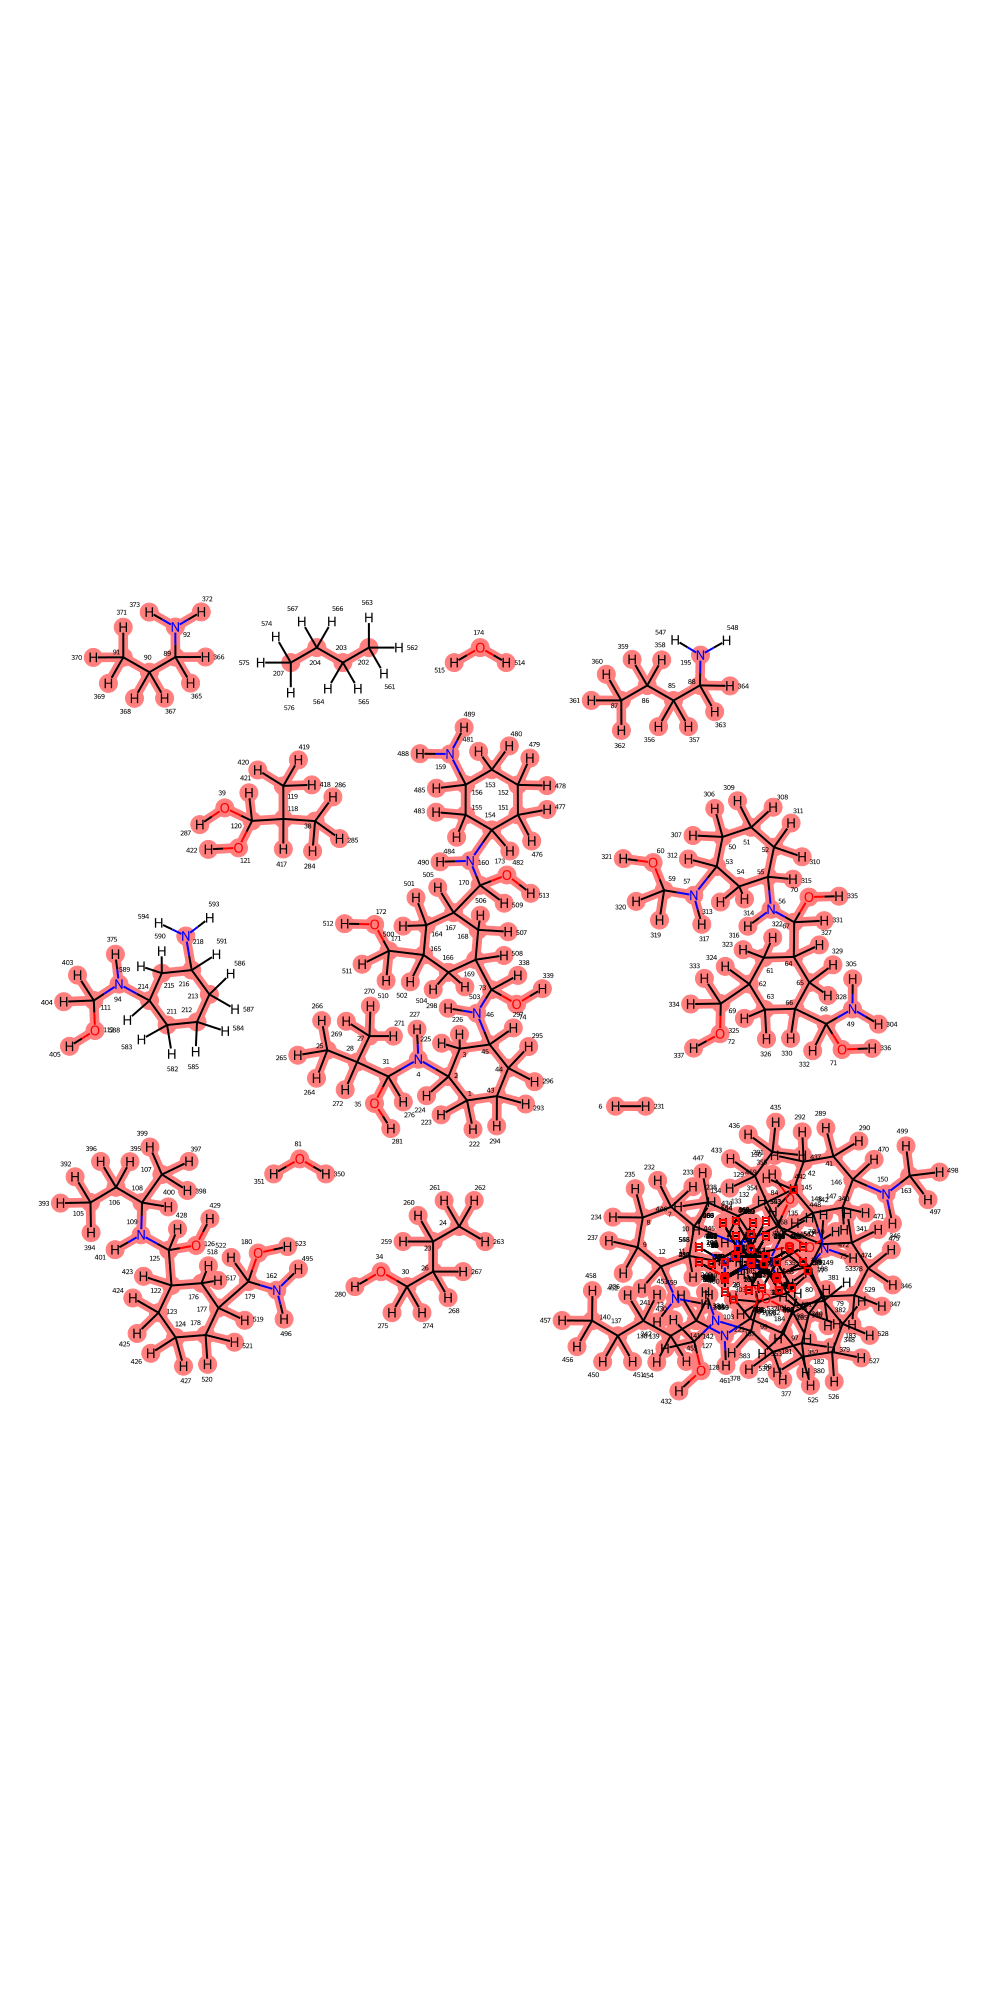

In [76]:
rdmol = Chem.rdmolfiles.MolFromPDBBlock(block1)
newmol = Molecule.from_rdkit(rdmol, allow_undefined_stereo=True)
selected_atoms = get_atoms_between(mol, [9999,999999], 447, inclusive_wall_ids = [])
# smarts, rdmol_sub = get_smarts_substructure_from_rdkit_idx(rdmol, ids=selected_atoms)
newmol.visualize(backend='rdkit', height=2000, width=1000, highlight_ids=selected_atoms)

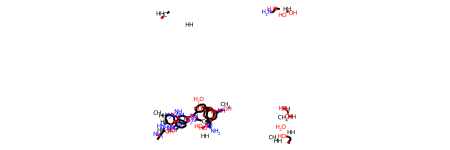

In [68]:
rdmol